In [1]:
import pandas as pd
import numpy as np
import psycopg2 as psql
import matplotlib.pyplot as plt
plt.style.use('seaborn-colorblind')
conn = psql.connect(dbname='datawarehouse',
                       host='localhost', user='gabriel', password='gyfu')

In [2]:
fireWeatherDataDB = pd.DataFrame(data={})

In [3]:
windowSize = 3
for city in range(1, 31):
    cur = conn.cursor()
    cur.execute('select d.day, d.month, d.year, count(f.*) from date d left join fires f on d.id = f.dateid and f.locationid = {} group by d.day, d.month, d.year order by d.year, d.month, d.day asc;'.format(city))
    fireCount = cur.fetchall()
    cur.close()
    cur = conn.cursor()
    cur.execute('select d.day, d.month, d.year, w.mimtemp, w.maxtemp, w.rainfall, w.windgustdir, w.windgustspeed from date d left join weather w on d.id = w.dateid and w.locationid = {} order by d.year, d.month, d.day asc;'.format(city))
    weatherData = cur.fetchall()
    cur.close()

    index = []
    count = []
    location = []
    for day in fireCount:
        index.append((day[0], day[1], day[2], city))
        count.append(day[3])
        location.append(city)

    fireCountDB = pd.DataFrame(data={'index': index, 'city': location, 'count': count})

    df = pd.DataFrame()
    for i in range(0, windowSize + 1):
        df['E{}'.format(i)] = fireCountDB['count'].shift(-i)
    df = df.iloc[:-windowSize]
    arr = df.values
    pDays = arr[:, :-1]

    pDays = np.insert(pDays, 0, np.zeros((3, 3)), axis=0)
    
    for i in range(0, windowSize):
        fireCountDB.insert((2 + i), "countDay{}".format(-windowSize + i), pDays[:, i])

    for i in range(0, windowSize):
        fireCountDB = fireCountDB.drop(i)
    fireCountDB = fireCountDB.set_index('index')

    index = []
    mimtemp = []
    maxtemp = []
    rainfall = []
    windgustdir = []
    windgustspeed = []
    location = []
    for day in weatherData:
        index.append((day[0], day[1], day[2], city))
        mimtemp.append(day[3])
        maxtemp.append(day[4])
        rainfall.append(day[5])
        windgustdir.append(day[6])
        windgustspeed.append(day[7])

    weatherDataDB = pd.DataFrame(data={'index': index, 'mimtemp': mimtemp, 'maxtemp': maxtemp, 'rainfall': rainfall, 'windgustdir': windgustdir, 'windgustspeed': windgustspeed})

    for i in range(0, windowSize):
        weatherDataDB = weatherDataDB.drop(i)
    weatherDataDB = weatherDataDB.set_index('index')
    sup = weatherDataDB.merge(fireCountDB, left_index=True, right_index=True)

    fireWeatherDataDB = fireWeatherDataDB.append(sup, ignore_index=False)


In [4]:
fireWeatherDataDB

mimtemp maxtemp rainfall windgustdir  windgustspeed  city  \
index                                                                         
(4, 1, 2008, 1)      None    None     None        None            NaN     1   
(5, 1, 2008, 1)      None    None     None        None            NaN     1   
(6, 1, 2008, 1)      None    None     None        None            NaN     1   
(7, 1, 2008, 1)      None    None     None        None            NaN     1   
(8, 1, 2008, 1)      None    None     None        None            NaN     1   
...                   ...     ...      ...         ...            ...   ...   
(21, 6, 2017, 30)    None    None     None        None            NaN    30   
(22, 6, 2017, 30)    None    None     None        None            NaN    30   
(23, 6, 2017, 30)    None    None     None        None            NaN    30   
(24, 6, 2017, 30)    None    None     None        None            NaN    30   
(25, 6, 2017, 30)    None    None     None        None            NaN    30   

                   countDay-3  countDay-2  countDay-1  count  
index                                                         
(4, 1, 2008, 1)           0.0         0.0         0.0      0  
(5, 1, 2008, 1)           0.0         0.0         0.0      0  
(6, 1, 2008, 1)           0.0         0.0         0.0      0  
(7, 1, 2008, 1)           0.0         0.0         0.0      0  
(8, 1, 2008, 1)           0.0         0.0         0.0      0  
...                       ...         ...         ...    ...  
(21, 6, 2017, 30)         0.0         0.0         0.0      0  
(22, 6, 2017, 30)         0.0         0.0         0.0      0  
(23, 6, 2017, 30)         0.0         0.0         0.0      1  
(24, 6, 2017, 30)         0.0         0.0         1.0      3  
(25, 6, 2017, 30)         0.0         1.0         3.0      1  

[103830 rows x 10 columns]

In [5]:
fireWeatherDataDB = fireWeatherDataDB[fireWeatherDataDB.mimtemp.notnull()]
fireWeatherDataDB = fireWeatherDataDB[fireWeatherDataDB.maxtemp.notnull()]
fireWeatherDataDB = fireWeatherDataDB[fireWeatherDataDB.rainfall.notnull()]
fireWeatherDataDB = fireWeatherDataDB[fireWeatherDataDB.windgustdir.notnull()]
fireWeatherDataDB = fireWeatherDataDB[fireWeatherDataDB.windgustspeed.notnull()]
fireWeatherDataDB

mimtemp maxtemp rainfall windgustdir  windgustspeed  city  \
index                                                                         
(7, 10, 2010, 1)     16.3    23.1      0.0         SSE           50.0     1   
(8, 10, 2010, 1)     13.8    19.5      0.0         ESE           35.0     1   
(9, 10, 2010, 1)     15.8    18.9      0.0         ESE           31.0     1   
(11, 10, 2010, 1)    16.5    21.1      1.2         ENE           56.0     1   
(12, 10, 2010, 1)    16.4    21.8      1.0         NNE           50.0     1   
...                   ...     ...      ...         ...            ...   ...   
(21, 6, 2017, 29)     8.9    13.1      0.8         SSE           26.0    29   
(22, 6, 2017, 29)     7.5    15.1      0.0         NW            26.0    29   
(23, 6, 2017, 29)     5.6    14.2      0.0         NNW           26.0    29   
(24, 6, 2017, 29)     6.2    11.8      3.0         W             20.0    29   
(25, 6, 2017, 29)     5.9    13.4      0.2         NW            31.0    29   

                   countDay-3  countDay-2  countDay-1  count  
index                                                         
(7, 10, 2010, 1)          0.0         0.0         0.0      0  
(8, 10, 2010, 1)          0.0         0.0         0.0      0  
(9, 10, 2010, 1)          0.0         0.0         0.0      0  
(11, 10, 2010, 1)         0.0         0.0         0.0      0  
(12, 10, 2010, 1)         0.0         0.0         0.0      1  
...                       ...         ...         ...    ...  
(21, 6, 2017, 29)         0.0         0.0         3.0      1  
(22, 6, 2017, 29)         0.0         3.0         1.0      0  
(23, 6, 2017, 29)         3.0         1.0         0.0      0  
(24, 6, 2017, 29)         1.0         0.0         0.0      0  
(25, 6, 2017, 29)         0.0         0.0         0.0      0  

[77377 rows x 10 columns]

In [6]:
from sklearn.preprocessing import LabelEncoder
enc = LabelEncoder()
fireWeatherDataDB['windgustdir'] = enc.fit_transform(fireWeatherDataDB['windgustdir'])
fireWeatherDataDB

mimtemp maxtemp rainfall  windgustdir  windgustspeed  city  \
index                                                                          
(7, 10, 2010, 1)     16.3    23.1      0.0           10           50.0     1   
(8, 10, 2010, 1)     13.8    19.5      0.0            2           35.0     1   
(9, 10, 2010, 1)     15.8    18.9      0.0            2           31.0     1   
(11, 10, 2010, 1)    16.5    21.1      1.2            1           56.0     1   
(12, 10, 2010, 1)    16.4    21.8      1.0            5           50.0     1   
...                   ...     ...      ...          ...            ...   ...   
(21, 6, 2017, 29)     8.9    13.1      0.8           10           26.0    29   
(22, 6, 2017, 29)     7.5    15.1      0.0            7           26.0    29   
(23, 6, 2017, 29)     5.6    14.2      0.0            6           26.0    29   
(24, 6, 2017, 29)     6.2    11.8      3.0           13           20.0    29   
(25, 6, 2017, 29)     5.9    13.4      0.2            7           31.0    29   

                   countDay-3  countDay-2  countDay-1  count  
index                                                         
(7, 10, 2010, 1)          0.0         0.0         0.0      0  
(8, 10, 2010, 1)          0.0         0.0         0.0      0  
(9, 10, 2010, 1)          0.0         0.0         0.0      0  
(11, 10, 2010, 1)         0.0         0.0         0.0      0  
(12, 10, 2010, 1)         0.0         0.0         0.0      1  
...                       ...         ...         ...    ...  
(21, 6, 2017, 29)         0.0         0.0         3.0      1  
(22, 6, 2017, 29)         0.0         3.0         1.0      0  
(23, 6, 2017, 29)         3.0         1.0         0.0      0  
(24, 6, 2017, 29)         1.0         0.0         0.0      0  
(25, 6, 2017, 29)         0.0         0.0         0.0      0  

[77377 rows x 10 columns]

In [7]:
from sklearn.preprocessing import StandardScaler
for colum in fireWeatherDataDB.columns.values:
    scaler = StandardScaler()
    scaler_data = fireWeatherDataDB[colum].values.copy()
    scaler_data.shape = (len(scaler_data), 1)
    fireWeatherDataDB[colum] = scaler.fit_transform(scaler_data)
fireWeatherDataDB

mimtemp   maxtemp  rainfall  windgustdir  windgustspeed  \
index                                                                         
(7, 10, 2010, 1)   0.821600  0.162876 -0.293159     0.445724       0.726605   
(8, 10, 2010, 1)   0.405428 -0.363212 -0.293159    -1.300068      -0.315323   
(9, 10, 2010, 1)   0.738366 -0.450893 -0.293159    -1.300068      -0.593171   
(11, 10, 2010, 1)  0.854894 -0.129395 -0.145687    -1.518293       1.143377   
(12, 10, 2010, 1)  0.838247 -0.027100 -0.170265    -0.645396       0.726605   
...                     ...       ...       ...          ...            ...   
(21, 6, 2017, 29) -0.410269 -1.298478 -0.194844     0.445724      -0.940481   
(22, 6, 2017, 29) -0.643326 -1.006207 -0.293159    -0.208948      -0.940481   
(23, 6, 2017, 29) -0.959616 -1.137729 -0.293159    -0.427172      -0.940481   
(24, 6, 2017, 29) -0.859735 -1.488454  0.075521     1.100396      -1.357252   
(25, 6, 2017, 29) -0.909676 -1.254637 -0.268580    -0.208948      -0.593171   

                       city  countDay-3  countDay-2  countDay-1     count  
index                                                                      
(7, 10, 2010, 1)  -1.717949   -0.261270   -0.262089   -0.264637 -0.262718  
(8, 10, 2010, 1)  -1.717949   -0.261270   -0.262089   -0.264637 -0.262718  
(9, 10, 2010, 1)  -1.717949   -0.261270   -0.262089   -0.264637 -0.262718  
(11, 10, 2010, 1) -1.717949   -0.261270   -0.262089   -0.264637 -0.262718  
(12, 10, 2010, 1) -1.717949   -0.261270   -0.262089   -0.264637 -0.140730  
...                     ...         ...         ...         ...       ...  
(21, 6, 2017, 29)  1.686677   -0.261270   -0.262089    0.106656 -0.140730  
(22, 6, 2017, 29)  1.686677   -0.261270    0.105478   -0.140873 -0.262718  
(23, 6, 2017, 29)  1.686677    0.105228   -0.139567   -0.264637 -0.262718  
(24, 6, 2017, 29)  1.686677   -0.139104   -0.262089   -0.264637 -0.262718  
(25, 6, 2017, 29)  1.686677   -0.261270   -0.262089   -0.264637 -0.262718  

[77377 rows x 10 columns]

In [8]:
target = fireWeatherDataDB.values[:, -1]
x = fireWeatherDataDB.values[:, :-1]
print(x)
print(target)

[[ 0.8216004   0.16287563 -0.29315885 ... -0.26126958 -0.26208888
  -0.26463701]
 [ 0.40542826 -0.36321156 -0.29315885 ... -0.26126958 -0.26208888
  -0.26463701]
 [ 0.73836597 -0.45089276 -0.29315885 ... -0.26126958 -0.26208888
  -0.26463701]
 ...
 [-0.95961634 -1.13772881 -0.29315885 ...  0.1052281  -0.13956655
  -0.26463701]
 [-0.85973503 -1.4884536   0.07552139 ... -0.13910368 -0.26208888
  -0.26463701]
 [-0.90967569 -1.25463708 -0.26858017 ... -0.26126958 -0.26208888
  -0.26463701]]
[-0.26271835 -0.26271835 -0.26271835 ... -0.26271835 -0.26271835
 -0.26271835]


In [12]:
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import cross_val_predict, GridSearchCV
from sklearn import metrics

scoring = ['r2', 'neg_mean_squared_error']

param_MLPR = {'hidden_layer_sizes': [(50,100,200,400,200,100,50,), (50, 100, 50,), (25,11,7,5,3,), (50, 100, 150, 150, 100, 50, )], 'activation':['relu', 'tanh','logistic', 'identity'], 'max_iter': [500, 1000, 1500]}

mlpr = MLPRegressor()
gsmlpr = GridSearchCV(mlpr, param_MLPR, cv=10, scoring=scoring, refit='neg_mean_squared_error')
gsmlpr.fit(x, target)
fullPredictMLPR = cross_val_predict(gsmlpr.best_estimator_, x, target, cv=10)

print('Mean Squared Error: %s' %(metrics.mean_squared_error(target, fullPredictMLPR)))
print('R2: %s' %(metrics.r2_score(target, fullPredictMLPR)))

fireWeatherDataDB['predictMLPR'] = fullPredictMLPR

C:\Python39\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
Mean Squared Error: 0.7079531704044516
R2: 0.2920468295955485


In [13]:
from sklearn.linear_model import LinearRegression

param_LR = {'fit_intercept': [True, False], 'normalize': [True, False], 'copy_X': [True, False], 'positive': [True, False]}

lR = LinearRegression()
gslr = GridSearchCV(lR, param_LR, cv=10, scoring=scoring, refit='neg_mean_squared_error')
gslr.fit(x, target)
fullPredictLR = cross_val_predict(gslr.best_estimator_, x, target, cv=10)
print('Mean Squared Error: %s' %(metrics.mean_squared_error(target, fullPredictLR)))
print('R2: %s' %(metrics.r2_score(target, fullPredictLR)))

fireWeatherDataDB['predictLR'] = fullPredictLR

Mean Squared Error: 0.6920413929656735
R2: 0.30795860703432665


<AxesSubplot:xlabel='index'>

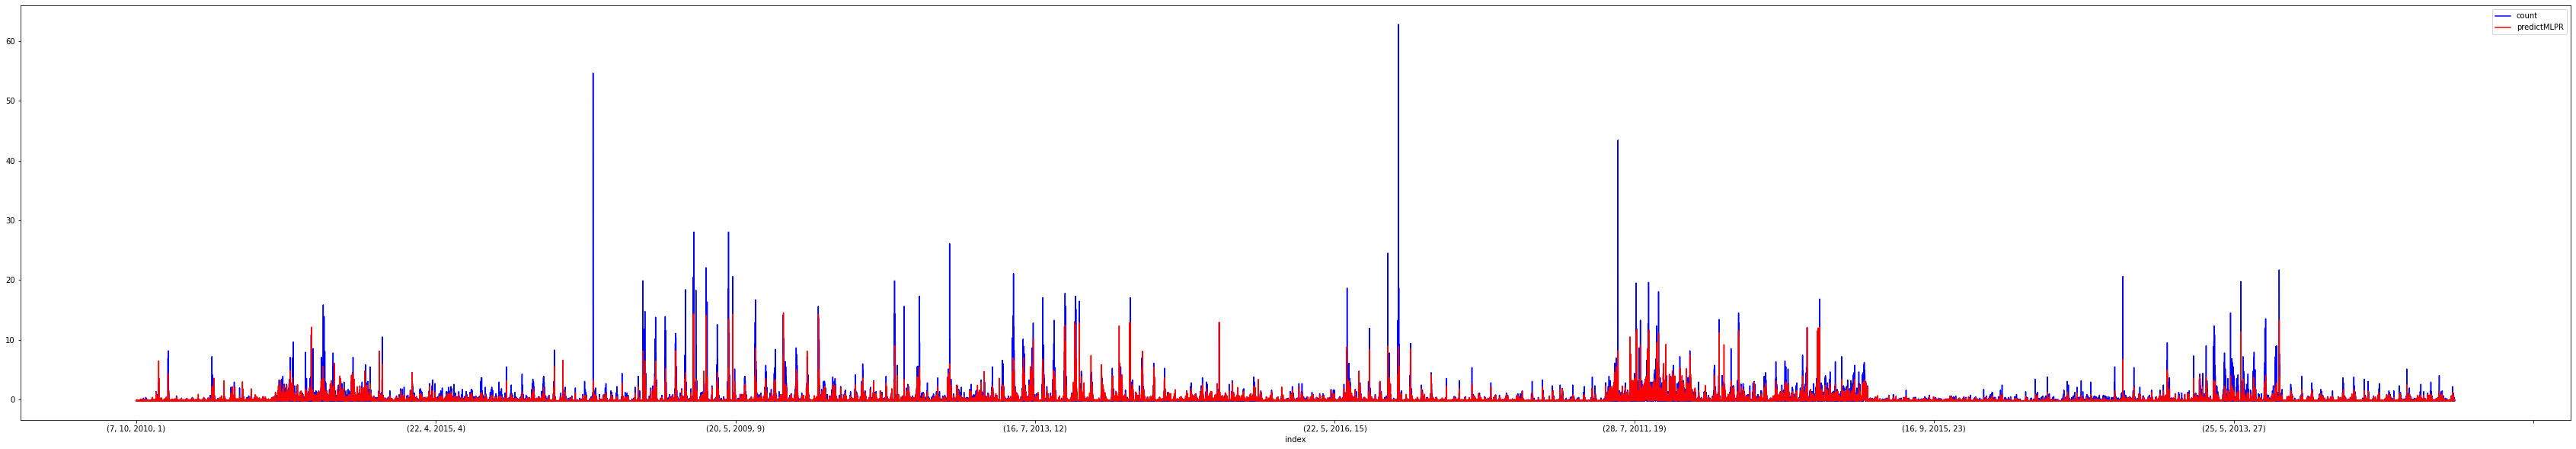

In [14]:
fireWeatherDataDB.plot(y=['count', 'predictMLPR'], figsize=(60,10), color=['blue', 'red'])

<AxesSubplot:xlabel='index'>

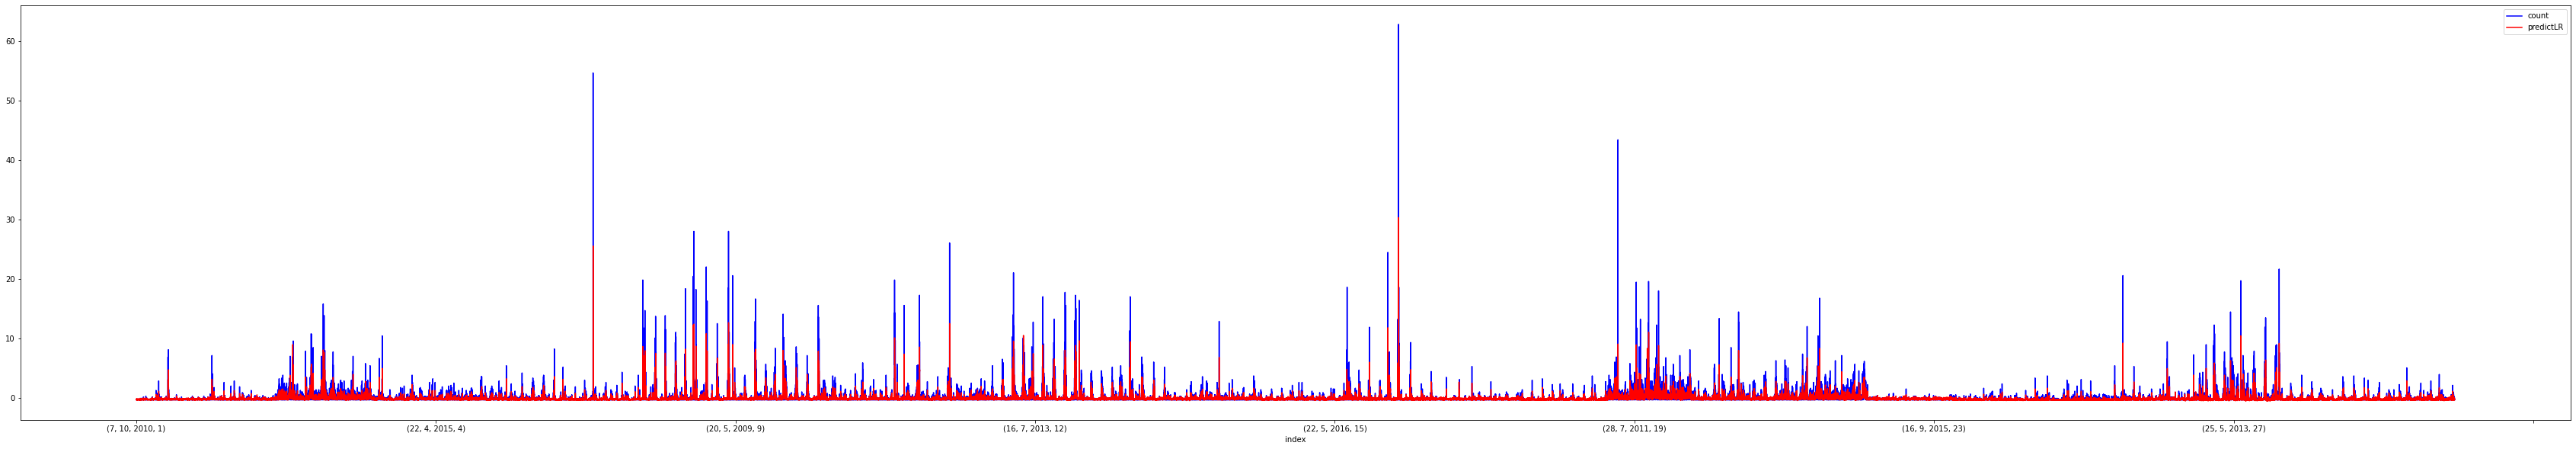

In [15]:
fireWeatherDataDB.plot(y=['count', 'predictLR'], figsize=(60,10), color=['blue', 'red'])

In [16]:
gsmlpr.cv_results_

_layer_sizes': (50, 100, 150, 150, 100, 50),
   'max_iter': 1000},
  {'activation': 'logistic',
   'hidden_layer_sizes': (50, 100, 150, 150, 100, 50),
   'max_iter': 1500},
  {'activation': 'identity',
   'hidden_layer_sizes': (50, 100, 200, 400, 200, 100, 50),
   'max_iter': 500},
  {'activation': 'identity',
   'hidden_layer_sizes': (50, 100, 200, 400, 200, 100, 50),
   'max_iter': 1000},
  {'activation': 'identity',
   'hidden_layer_sizes': (50, 100, 200, 400, 200, 100, 50),
   'max_iter': 1500},
  {'activation': 'identity',
   'hidden_layer_sizes': (50, 100, 50),
   'max_iter': 500},
  {'activation': 'identity',
   'hidden_layer_sizes': (50, 100, 50),
   'max_iter': 1000},
  {'activation': 'identity',
   'hidden_layer_sizes': (50, 100, 50),
   'max_iter': 1500},
  {'activation': 'identity',
   'hidden_layer_sizes': (25, 11, 7, 5, 3),
   'max_iter': 500},
  {'activation': 'identity',
   'hidden_layer_sizes': (25, 11, 7, 5, 3),
   'max_iter': 1000},
  {'activation': 'identity',
   'h

In [22]:
results_CVMLPR = pd.DataFrame(gsmlpr.cv_results_)
results_CVMLPR

0.008093  ...                           -0.910652   
1         0.281561  ...                           -1.004770   
2         0.110762  ...                           -0.974763   
3         0.209986  ...                           -0.972719   
4         0.047099  ...                           -1.086236   
5         0.122311  ...                           -1.012549   
6         0.199395  ...                           -0.961394   
7         0.278138  ...                           -0.982024   
8         0.209311  ...                           -0.887301   
9         0.115046  ...                           -0.966456   
10        0.137560  ...                           -1.057636   
11        0.171989  ...                           -0.985876   
12        0.115822  ...                           -0.842133   
13        0.173530  ...                           -0.861382   
14        0.148124  ...                           -0.836668   
15       -0.022805  ...                           -1.155445   
16        0.079029  ...                           -1.075855   
17        0.194271  ...                           -1.232520   
18        0.118800  ...                           -0.994394   
19        0.098024  ...                           -0.789322   
20        0.183134  ...                           -0.890372   
21        0.179570  ...                           -0.774618   
22        0.023143  ...                           -0.814341   
23        0.150934  ...                           -0.801030   
24        0.183399  ...                           -1.269317   
25       -0.004362  ...                           -1.270435   
26        0.153445  ...                           -0.791302   
27        0.192984  ...                           -0.769885   
28       -0.002109  ...                           -0.764954   
29        0.288241  ...                           -0.766631   
30        0.146685  ...                           -0.788169   
31        0.267036  ...                           -0.819381   
32        0.153488  ...                           -0.929783   
33        0.140805  ...                           -0.796876   
34        0.175799  ...                           -0.777637   
35        0.167395  ...                           -0.773447   
36        0.202597  ...                           -1.154064   
37        0.184902  ...                           -0.925951   
38        0.291937  ...                           -0.918758   
39        0.263651  ...                           -0.902687   
40        0.270051  ...                           -0.893206   
41        0.269318  ...                           -0.922067   
42        0.251370  ...                           -0.897376   
43        0.256734  ...                           -0.905487   
44        0.252919  ...                           -0.891780   
45        0.266526  ...                           -0.909171   
46        0.281609  ...                           -0.917690   
47        0.235030  ...                           -0.882437   

    split4_test_neg_mean_squared_error  split5_test_neg_mean_squared_error  \
0                            -0.591464                           -0.813196   
1                            -0.649945                           -0.942817   
2                            -0.855701                           -0.972097   
3                            -0.941868                           -1.007799   
4                            -0.853088                           -0.978086   
5                            -0.865960                           -1.014717   
6                            -0.626858                           -0.973898   
7                            -0.668474                           -0.822476   
8                            -0.527522                           -1.032784   
9                            -0.719806                           -0.964330   
10                           -0.689116                           -1.020101   
11                           -0.860159           

In [28]:
results_CVMLPR.to_csv('../Visual Resourses/GridS/results_CVMLPR.csv', header=results_CVMLPR.columns.values, index=False)

In [17]:
gsmlpr.best_params_

{'activation': 'logistic',
 'hidden_layer_sizes': (25, 11, 7, 5, 3),
 'max_iter': 1000}

In [18]:
gslr.cv_results_

{'mean_fit_time': array([0.02480216, 0.02492106, 0.02470264, 0.01923854, 0.01910987,
        0.01539938, 0.01949689, 0.01513119, 0.02201071, 0.01999354,
        0.01979845, 0.0177654 , 0.01700926, 0.01337771, 0.01679928,
        0.01350391]),
 'std_fit_time': array([0.0021803 , 0.00718181, 0.00466855, 0.00088266, 0.00096131,
        0.00049677, 0.00110821, 0.00094786, 0.00089218, 0.00082761,
        0.0009675 , 0.00135659, 0.00125823, 0.00078382, 0.00107647,
        0.00092318]),
 'mean_score_time': array([0.00130799, 0.00110118, 0.00119026, 0.00113108, 0.00138142,
        0.00118349, 0.00109897, 0.00116718, 0.001284  , 0.00104387,
        0.00119493, 0.00152116, 0.00138674, 0.00110435, 0.0012866 ,
        0.00098925]),
 'std_score_time': array([0.00046453, 0.00030503, 0.00040604, 0.00045699, 0.00049674,
        0.00040954, 0.00030228, 0.00029878, 0.00044989, 0.00036157,
        0.00040588, 0.00049931, 0.00048242, 0.00030373, 0.00045594,
        0.00038396]),
 'param_copy_X': masked_ar

In [30]:
results_CVLR = pd.DataFrame(gslr.cv_results_)
results_CVLR

mean_fit_time  std_fit_time  mean_score_time  std_score_time param_copy_X  \
0        0.024802      0.002180         0.001308        0.000465         True   
1        0.024921      0.007182         0.001101        0.000305         True   
2        0.024703      0.004669         0.001190        0.000406         True   
3        0.019239      0.000883         0.001131        0.000457         True   
4        0.019110      0.000961         0.001381        0.000497         True   
5        0.015399      0.000497         0.001183        0.000410         True   
6        0.019497      0.001108         0.001099        0.000302         True   
7        0.015131      0.000948         0.001167        0.000299         True   
8        0.022011      0.000892         0.001284        0.000450        False   
9        0.019994      0.000828         0.001044        0.000362        False   
10       0.019798      0.000967         0.001195        0.000406        False   
11       0.017765      0.001357         0.001521        0.000499        False   
12       0.017009      0.001258         0.001387        0.000482        False   
13       0.013378      0.000784         0.001104        0.000304        False   
14       0.016799      0.001076         0.001287        0.000456        False   
15       0.013504      0.000923         0.000989        0.000384        False   

   param_fit_intercept param_normalize param_positive  \
0                 True            True           True   
1                 True            True          False   
2                 True           False           True   
3                 True           False          False   
4                False            True           True   
5                False            True          False   
6                False           False           True   
7                False           False          False   
8                 True            True           True   
9                 True            True          False   
10                True           False           True   
11                True           False          False   
12               False            True           True   
13               False            True          False   
14               False           False           True   
15               False           False          False   

                                               params  split0_test_r2  ...  \
0   {'copy_X': True, 'fit_intercept': True, 'norma...        0.339781  ...   
1   {'copy_X': True, 'fit_intercept': True, 'norma...        0.346609  ...   
2   {'copy_X': True, 'fit_intercept': True, 'norma...        0.339781  ...   
3   {'copy_X': True, 'fit_intercept': True, 'norma...        0.346609  ...   
4   {'copy_X': True, 'fit_intercept': False, 'norm...        0.339847  ...   
5   {'copy_X': True, 'fit_intercept': False, 'norm...        0.346664  ...   
6   {'copy_X': True, 'fit_intercept': False, 'norm...        0.339847  ...   
7   {'copy_X': True, 'fit_intercept': False, 'norm...        0.346664  ...   
8   {'copy_X': False, 'fit_intercept': True, 'norm...        0.339781  ...   
9   {'copy_X': False, 'fit_intercept': True, 'norm...        0.346609  ...   
10  {'copy_X': False, 'fit_intercept': True, 'norm...        0.339781  ...   
11  {'copy_X': False, 'fit_intercept': True, 'norm...        0.346609  ...   
12  {'copy_X': False, 'fit_intercept': False, 'nor...        0.339847  ...   
13  {'copy_X': False, 'fit_intercept': False, 'nor...        0.346664  ...   
14  {'copy_X': False, 'fit_intercept': False, 'nor...        0.339847  ...   
15  {'copy_X': False, 'fit_intercept': False, 'nor...        0.346664  ...   

    split3_test_neg_mean_squared_error  split4_test_neg_mean_squared_error  \
0                            -0.907608                           -0.586566   
1                            -0.893300                           -0.584926   
2                            -0.907608                           -0.586566   
3                

In [31]:
results_CVLR.to_csv('../Visual Resourses/GridS/results_CVLR.csv', header=results_CVLR.columns.values, index=False)

In [19]:
gslr.best_params_

{'copy_X': True, 'fit_intercept': False, 'normalize': True, 'positive': False}